# Plot spill locations relavent to regional impact
Spill files generated with [pillLocationsByImpactRegion.ipynb](https://github.com/MIDOSS/analysis-rachael/blob/main/notebooks/monte_carlo/spillLocationsByImpactRegion.ipynb)

In [1]:
import os
import sys
import pathlib
import yaml
import numpy
import pandas
import xarray
import netCDF4 as nc
from cartopy import crs,feature
#import h5netcdf
from datetime import datetime
from datetime import date
from glob import glob
import time
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt, patches, colors
import matplotlib as mpl

In [2]:
# mapping specifications
import cartopy
rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()

In [3]:
if os.sys.platform=="darwin":
    spill_file_dir = pathlib.Path('/home/rmueller/Projects/MIDOSS/results/try3/SpillLocationImpacts')
else:
    spill_file_dir = pathlib.Path('/Volumes/Elements/MIDOSS_Data/SpillLocationImpacts')
spill_files = os.listdir(spill_file_dir)
locs = [filename.split('_')[0] for filename in spill_files]
loc_tags=list(set(locs))
liters_to_gal = 0.264172 * 1e-6

In [4]:
spill_files

['sji_SpillLocations.yaml',
 'cwchn_NONESpillLocations.yaml',
 'jdf_SpillLocations.yaml',
 'lummi_NONESpillLocations.yaml',
 'sog_SpillLocations.yaml',
 'sog_NONESpillLocations.yaml',
 'ps_SpillLocations.yaml',
 'sji_NONESpillLocations.yaml',
 'cwchn_SpillLocations.yaml',
 'ps_NONESpillLocations.yaml',
 'jdf_NONESpillLocations.yaml',
 'lummi_SpillLocations.yaml']

In [5]:
loc_tags

['lummi', 'ps', 'jdf', 'cwchn', 'sji', 'sog']

In [6]:
spillLocsByRegion={}
no_spillLocsByRegion={}
max_vol=0
for loc in loc_tags:
    with open(spill_file_dir/f"{loc}_SpillLocations.yaml", 'r') as file:
        spillLocsByRegion[loc] = yaml.safe_load(file)
    with open(spill_file_dir/f"{loc}_NONESpillLocations.yaml", 'r') as file:
        no_spillLocsByRegion[loc] = yaml.safe_load(file)
    max_vol=max(numpy.max(spillLocsByRegion[loc]['vol']),max_vol)
    max_vol=max(numpy.max(no_spillLocsByRegion[loc]['vol']),max_vol)

In [7]:
# mask = xarray.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
# coords = xarray.open_dataset('/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
# bathy = xarray.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
# spills = pandas.read_csv('/data/sallen/results/MIDOSS/Monte_Carlo/northern_strait.csv')

# # Load ETOPO1 data set
# topo = xarray.open_dataset('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/ETOPO1_Bed_g_gmt4.grd')

# # Crop to Salish Sea
# extent = [-126.5, -121.2, 46.8, 51.2]
# topo_salishsea = topo.sel(x=slice(*extent[:2]), y=slice(*extent[2:]))
# lon, lat = [coords[var][0, ...].values for var in ('glamt', 'gphit')]
# #lon, lat, depth = [topo_salishsea[var].values for var in ('x', 'y', 'z')]
# tmask = mask.tmask[0, 0, ...].values

In [8]:
# grid cell locations [y-grid,x-grid]
mask = nc.Dataset('/data/SalishSeaCast/grid/mesh_mask201702.nc')
lats = mask['nav_lat'][1:-1,1:-1]
lons = mask['nav_lon'][:]

# General regional interests
# Juan de Fuca
JDF = numpy.full(lons.shape, True)
JDF[225:475,0:170] = False
JDF_masked = numpy.ma.masked_where(JDF, numpy.ones(lons.shape))

# box method
jdf_edges=[[225,0],[225,173],[475,173],[475,0]]
jdf_box = numpy.array([[lons[edge[0],edge[1]],lats[edge[0],edge[1]]] for edge in jdf_edges])

# Puget Sound
PS = numpy.full(lons.shape, True)
PS[0:160,50:325] = False
PS_masked = numpy.ma.masked_where(PS, numpy.ones(lons.shape))

# box method
ps_edges=[[0,50],[0,325],[215,325],[215,50]]
ps_box = numpy.array([[lons[edge[0],edge[1]],lats[edge[0],edge[1]]] for edge in ps_edges])

# Strait of Georgia
SOG = numpy.full(lons.shape, True)
SOG[335:715,100:-1] = False
SOG_masked = numpy.ma.masked_where(SOG, numpy.ones(lons.shape))

# box method
SOG_edges=[[335,100],[335,-1],[715,-1],[715,100]]
sog_box = numpy.array([[lons[edge[0],edge[1]],lats[edge[0],edge[1]]] for edge in SOG_edges])

# Areas of import to two Coast Salish communities
# Cowichan
cwchn = numpy.full(lons.shape, True)
cwchn[340:500,150:295] = False
cwchn_masked = numpy.ma.masked_where(cwchn, numpy.ones(lons.shape))

# box method
cwchn_edges=[[340,150],[340,295],[500,295],[500,150]]
cwchn_box = numpy.array([[lons[edge[0],edge[1]],lats[edge[0],edge[1]]] for edge in cwchn_edges])

# SJI
sji = numpy.full(lons.shape, True)
sji[274:324,237:270] = False
sji_masked = numpy.ma.masked_where(sji, numpy.ones(lons.shape))

# box method
sji_edges=[[274,237],[274,270],[324,270],[324,237]]
sji_box = numpy.array([[lons[edge[0],edge[1]],lats[edge[0],edge[1]]] for edge in sji_edges])

# Lummi
lummi = numpy.full(lons.shape, True)
lummi[300:325,338:370] = False
lummi_masked = numpy.ma.masked_where(lummi, numpy.ones(lons.shape))

# box method
lummi_edges=[[300,338],[300,370],[325,370],[325,338]]
lummi_box = numpy.array([[lons[edge[0],edge[1]],lats[edge[0],edge[1]]] for edge in lummi_edges])



In [9]:
bathy = xarray.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
coords = xarray.open_dataset('/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
lon, lat = [coords[var][0, ...].values for var in ('glamt', 'gphit')]

# millions of gallons

[<matplotlib.lines.Line2D object at 0x7f249abfaaf0>, <matplotlib.lines.Line2D object at 0x7f249abfa880>, <matplotlib.lines.Line2D object at 0x7f249abfa5b0>, <matplotlib.lines.Line2D object at 0x7f249abfa6a0>]
[<matplotlib.lines.Line2D object at 0x7f24a4d81e80>, <matplotlib.lines.Line2D object at 0x7f24a4d81a30>, <matplotlib.lines.Line2D object at 0x7f24a4d810a0>, <matplotlib.lines.Line2D object at 0x7f24a4d81280>]


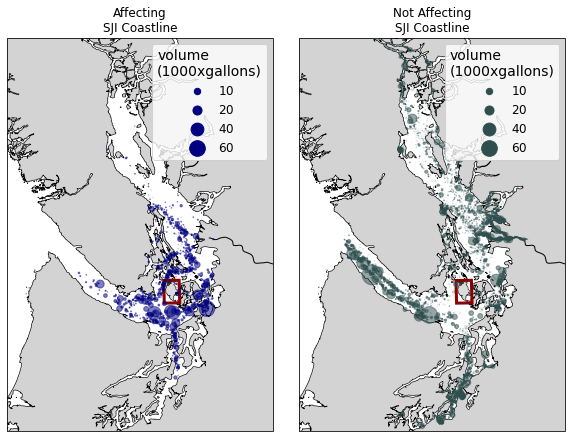

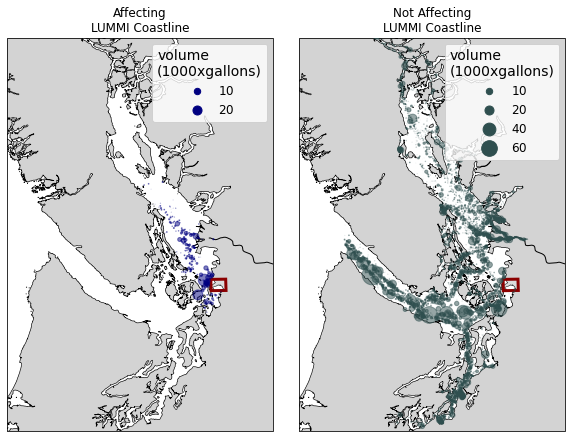

In [37]:
fs_legend = 12
fs_legend_title = 14
# scale for scatter plot marker size
ms=400
plt.rcParams['savefig.dpi']=400

graphics_directory = pathlib.Path('/ocean/rmueller/MIDOSS/graphics/')
for region in ['sji','lummi']:#loc_tags:#['sji','ps','lummi']:#
    # --------- Figure setup ---------
    proj_ref = crs.PlateCarree()
    lw = 1 # linewidth for regional boundary boxes
    fs = 12 #fontsize for colorbar

    # The code for this figure is a modified version of code from Ben Moore-Maley
    fig, axs = plt.subplots(1, 2, 
                  figsize=(10, 10), #(width, height)
                  subplot_kw={'projection': rotated_crs, 
                    "facecolor": "white"},
                  gridspec_kw={
                       'width_ratios': [1,1],
                       'height_ratios': [1],
                       'wspace': 0.1,
                      'hspace':-.2}
    )

    for subplot in [0,1]:
        # Make map
        extent = [-126.5, -121.2, 46.8, 51.2]
        proj = crs.Mercator(numpy.mean(extent[:2]), *extent[2:])
        axs[subplot].set_extent([-124, -123.75, lats.min()-0.15, lats.max()])      
        axs[subplot].add_feature(feature.GSHHSFeature(
            'full', edgecolor='k', linewidth=0.6, facecolor='lightgrey'))
        axs[subplot].add_feature(feature.NaturalEarthFeature(
            category='physical', name='rivers_lake_centerlines',
            scale='10m', facecolor='none', edgecolor='k',
        ))
        
        # Overlay region box
        domain_box = numpy.array(
            [(lons[ji], lats[ji]) for ji in [(0, 0), (0, -1), (-1, -1), (-1, 0)]])
        #c=axs[0].contourf(lon, lat, bathy.Bathymetry, levels=numpy.arange(0, 451, 50), cmap='Blues', extend='max', transform=proj_ref)
        p=axs[subplot].add_patch(patches.Polygon(locals()[f'{region}_box'], fc='w', ec='k', alpha=0.2, lw=lw, transform=proj_ref, zorder=3))
        p=axs[subplot].add_patch(patches.Polygon(locals()[f'{region}_box'], fc='none', ec='darkred', lw=3, transform=proj_ref, zorder=3))


        # ~~~ Number of spills ~~~
        if subplot==0:
            spill_color = 'navy'
            # do coordinate conversion of (x,y)
            xynps = axs[subplot].projection.transform_points(
                crs.Geodetic(), 
                numpy.array(spillLocsByRegion[region]['lon']), 
                numpy.array(spillLocsByRegion[region]['lat']))
            # calculate histograms for number of spills and plot using pcolormesh
            s = [ms*vol/max_vol for vol in spillLocsByRegion[region]['vol']]
            scatter_transfers=axs[subplot].scatter(
                xynps[:,0], 
                xynps[:,1],
                color=spill_color,
                marker='o',
                zorder=4,
                s=s,
                alpha=0.5
            )
            # use "func" to convert values back and scale from liters to megaliters
            # see: https://matplotlib.org/stable/api/collections_api.html#matplotlib.collections.PathCollection.legend_elements
            handles, labels = scatter_transfers.legend_elements(
                prop="sizes", 
                color=spill_color, 
                num=[10, 20, 40, 60], 
                func=lambda x: max_vol*x/ms/1000,alpha=1)
            legend = axs[subplot].legend(
                handles, 
                labels, 
                loc="upper right", 
                title="volume\n(1000xgallons)",
                fontsize=fs_legend)
            plt.setp(legend.get_title(),fontsize=fs_legend_title)
            axs[subplot].set_title(f'Affecting\n{region.upper()} Coastline', fontsize=fs)
        else:
            # do coordinate conversion of (x,y)
            nospill_color = 'darkslategrey'
            xynps = axs[subplot].projection.transform_points(
                crs.Geodetic(), 
                numpy.array(no_spillLocsByRegion[region]['lon']), 
                numpy.array(no_spillLocsByRegion[region]['lat']))
             # calculate histograms for number of spills and plot using pcolormesh
            s = [ms*vol/max_vol for vol in no_spillLocsByRegion[region]['vol']]
            scatter_transfers=axs[subplot].scatter(
                xynps[:,0], 
                xynps[:,1],
                color=nospill_color,
                edgecolor=nospill_color,
                marker='o',
                zorder=4,
                s=s,
                alpha=0.5
            )
            # use "func" to convert values back and scale from liters to megaliters
            # see: https://matplotlib.org/stable/api/collections_api.html#matplotlib.collections.PathCollection.legend_elements
            handles, labels = scatter_transfers.legend_elements(
                prop="sizes", color=nospill_color, 
                num=[10, 20, 40, 60], 
                func=lambda x: max_vol*x/ms/1000,
                alpha=1)

            print(handles)
            # handles, labels = scatter_transfers.legend_elements(
            #     prop="sizes", color=nospill_color, num=4, alpha=1)
            legend = axs[subplot].legend(
                handles, 
                labels, 
                loc="upper right", 
                title="volume\n(1000xgallons)", 
                fontsize=fs_legend)
            plt.setp(legend.get_title(),fontsize=fs_legend_title)
            axs[subplot].set_title(f'Not Affecting\n{region.upper()} Coastline', fontsize=fs)
   
    plt.savefig(graphics_directory/f'Spills_vs_NoSpills_byRegion_{region}_gallons.png')
    



# megaliters

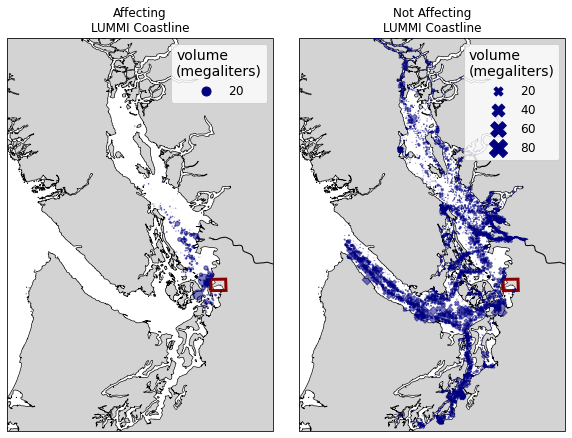

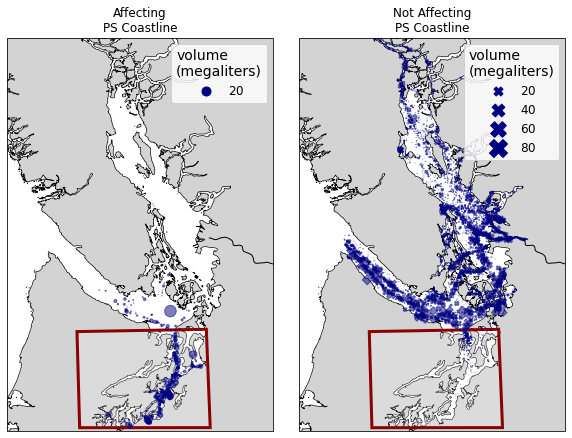

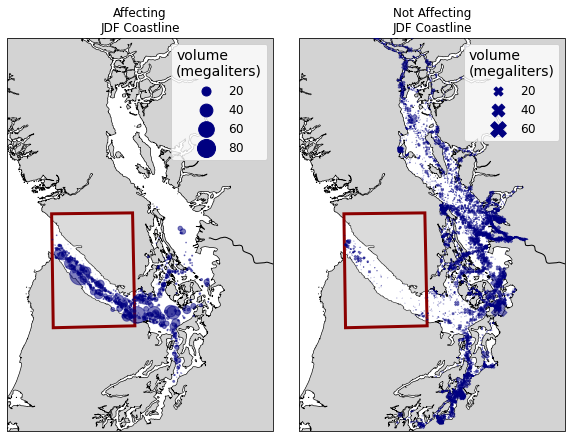

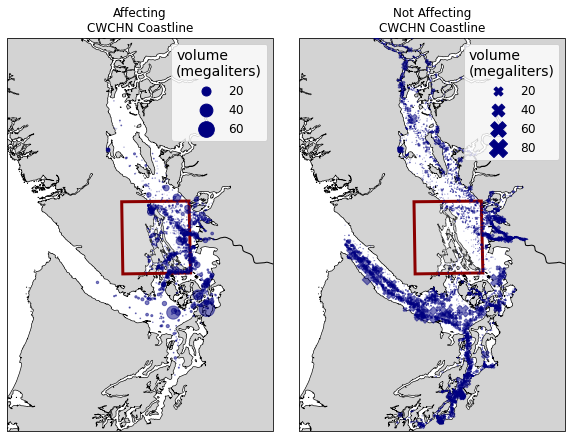

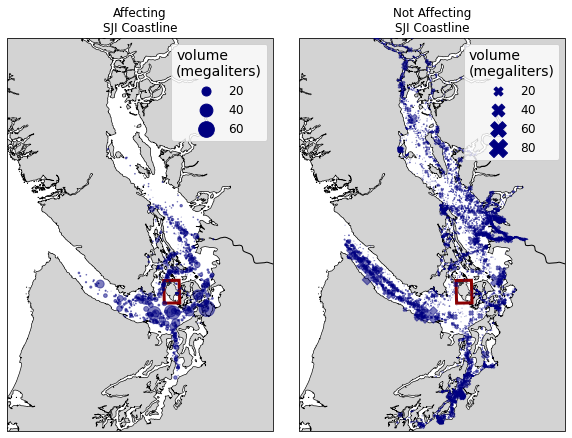

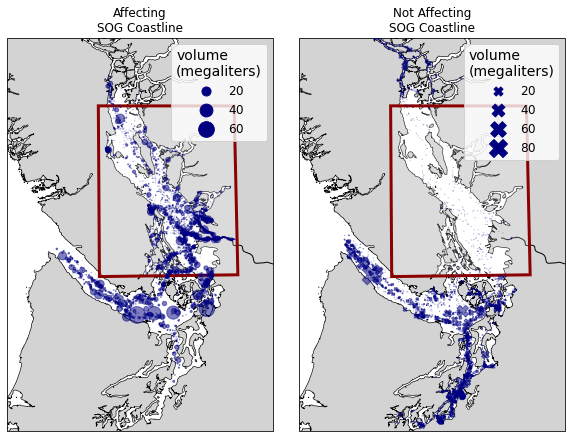

In [26]:
fs_legend = 12
fs_legend_title = 14
# scale for scatter plot marker size
ms=400

graphics_directory = pathlib.Path('/ocean/rmueller/MIDOSS/graphics/')
for region in loc_tags:#['sji','ps','lummi']:
    # --------- Figure setup ---------
    proj_ref = crs.PlateCarree()
    lw = 1 # linewidth for regional boundary boxes
    fs = 12 #fontsize for colorbar

    # The code for this figure is a modified version of code from Ben Moore-Maley
    fig, axs = plt.subplots(1, 2, 
                  figsize=(10, 10), #(width, height)
                  subplot_kw={'projection': rotated_crs, 
                    "facecolor": "white"},
                  gridspec_kw={
                       'width_ratios': [1,1],
                       'height_ratios': [1],
                       'wspace': 0.1,
                      'hspace':-.2}
    )

    for subplot in [0,1]:
        # Make map
        extent = [-126.5, -121.2, 46.8, 51.2]
        proj = crs.Mercator(numpy.mean(extent[:2]), *extent[2:])
        axs[subplot].set_extent([-124, -123.75, lats.min()-0.15, lats.max()])      
        axs[subplot].add_feature(feature.GSHHSFeature(
            'full', edgecolor='k', linewidth=0.6, facecolor='lightgrey'))
        axs[subplot].add_feature(feature.NaturalEarthFeature(
            category='physical', name='rivers_lake_centerlines',
            scale='10m', facecolor='none', edgecolor='k',
        ))
        
        # Overlay region box
        domain_box = numpy.array(
            [(lons[ji], lats[ji]) for ji in [(0, 0), (0, -1), (-1, -1), (-1, 0)]])
        #c=axs[0].contourf(lon, lat, bathy.Bathymetry, levels=numpy.arange(0, 451, 50), cmap='Blues', extend='max', transform=proj_ref)
        p=axs[subplot].add_patch(patches.Polygon(locals()[f'{region}_box'], fc='w', ec='k', alpha=0.2, lw=lw, transform=proj_ref, zorder=3))
        p=axs[subplot].add_patch(patches.Polygon(locals()[f'{region}_box'], fc='none', ec='darkred', lw=3, transform=proj_ref, zorder=3))


        # ~~~ Number of spills ~~~
        if subplot==0:
            spill_color = 'navy'
            # do coordinate conversion of (x,y)
            xynps = axs[subplot].projection.transform_points(
                crs.Geodetic(), 
                numpy.array(spillLocsByRegion[region]['lon']), 
                numpy.array(spillLocsByRegion[region]['lat']))
            # calculate histograms for number of spills and plot using pcolormesh
            s = [ms*vol/max_vol for vol in spillLocsByRegion[region]['vol']]
            scatter_transfers=axs[subplot].scatter(
                xynps[:,0], 
                xynps[:,1],
                color=spill_color,
                marker='o',
                zorder=4,
                s=s,
                alpha=0.5
            )
            # use "func" to convert values back and scale from liters to megaliters
            # see: https://matplotlib.org/stable/api/collections_api.html#matplotlib.collections.PathCollection.legend_elements
            handles, labels = scatter_transfers.legend_elements(
                prop="sizes", color=spill_color, num=[20,40,60,80], func=lambda x: max_vol*x/400/1000,alpha=1)
            legend = axs[subplot].legend(
                handles, 
                labels, 
                loc="upper right", 
                title="volume\n(megaliters)", 
                fontsize=fs_legend)
            plt.setp(legend.get_title(),fontsize=fs_legend_title)
            axs[subplot].set_title(f'Affecting\n{region.upper()} Coastline', fontsize=fs)
        else:
            # do coordinate conversion of (x,y)
            nospill_color = 'navy'
            xynps = axs[subplot].projection.transform_points(
                crs.Geodetic(), 
                numpy.array(no_spillLocsByRegion[region]['lon']), 
                numpy.array(no_spillLocsByRegion[region]['lat']))
             # calculate histograms for number of spills and plot using pcolormesh
            s = [ms*vol/max_vol for vol in no_spillLocsByRegion[region]['vol']]
            scatter_transfers=axs[subplot].scatter(
                xynps[:,0], 
                xynps[:,1],
                color=nospill_color,
                edgecolor=nospill_color,
                marker='X',
                zorder=4,
                s=s,
                alpha=0.5
            )
            # use "func" to convert values back and scale from liters to megaliters
            # see: https://matplotlib.org/stable/api/collections_api.html#matplotlib.collections.PathCollection.legend_elements
            handles, labels = scatter_transfers.legend_elements(
                prop="sizes", color=spill_color, 
                num=[20,40,60,80], 
                func=lambda x: max_vol*x/400/1000,
                alpha=1)

            # handles, labels = scatter_transfers.legend_elements(
            #     prop="sizes", color=nospill_color, num=4, alpha=1)
            legend = axs[subplot].legend(
                handles, 
                labels, 
                loc="upper right", 
                title="volume\n(megaliters)", 
                fontsize=fs_legend)
            plt.setp(legend.get_title(),fontsize=fs_legend_title)
            axs[subplot].set_title(f'Not Affecting\n{region.upper()} Coastline', fontsize=fs)
   
    plt.savefig(graphics_directory/f'Spills_vs_NoSpills_byRegion_{region}_gallons.png')
    


In [ ]:
# get length of legend entries
            Nitems=5
            Nlegend_items=len(scatter_transfers.legend_elements("sizes", num=Nitems)[:][0])
            # legend_txt=[]
            # for idx,legend_item in enumerate(scatter_transfers.legend_elements("sizes", num=Nitems)[1][:]):
            #     legend_txt.append(
            #         max_vol*float(sc.legend_elements("sizes", num=Nitems)[1][idx].split("{")[1].split("}")[0])/ms)
            # handles, labels = scatter_transfers.legend_elements(
            #     prop="sizes", color=spill_color, num=Nitems, func=lambda x: max_vol*x/400,alpha=1)
            # for idx,legend_item in enumerate(scatter_transfers.legend_elements("sizes", num=[max_vol/4,max_vol/2])[1][:]):
            #     legend_txt.append(
            #         max_vol*float(sc.legend_elements("sizes", num=[max_vol/4,max_vol/2])[1][idx].split("{")[1].split("}")[0])/ms)
            

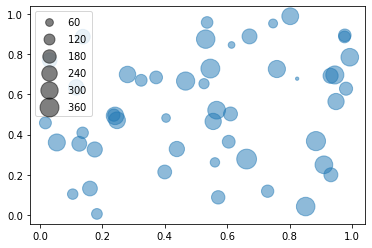

In [50]:
import numpy as np
import matplotlib.pyplot as plt

N = 50
x = np.random.rand(N)
y = np.random.rand(N)
a2 = 400*np.random.rand(N)

sc = plt.scatter(x, y, s=a2, alpha=0.5)
plt.legend(*sc.legend_elements("sizes", num=6))
plt.show()

In [77]:
# get length of legend entries
Nlegend_items=len(sc.legend_elements("sizes", num=6)[:][0])
for idx,legend_item in enumerate(sc.legend_elements("sizes", num=6)[1][:]):
    print(float(sc.legend_elements("sizes", num=6)[1][idx].split("{")[1].split("}")[0])/400)

In [86]:
for idx,legend_item in enumerate(sc.legend_elements("sizes", num=6)[1][:]):
    print(float(sc.legend_elements("sizes", num=6)[1][idx].split("{")[1].split("}")[0])/400)

0.15
0.3
0.45
0.6
0.75
0.9


In [49]:
import numpy as np
import pandas as pd
N=200
M=5
x = np.random.rand(N)
y = np.random.rand(N)
a2 = 400*np.random.rand(N)

# Create the DataFrame from your randomised data and bin it using groupby.
df = pd.DataFrame(data=dict(x=x, y=y, a2=a2))
bins = np.linspace(df.a2.min(), df.a2.max(), M)
grouped = df.groupby(np.digitize(df.a2, bins))

# Create some sizes and some labels.
sizes = [50*(i+1.) for i in range(M)]
labels = ['Tiny', 'Small', 'Medium', 'Large', 'Huge']

for i, (name, group) in enumerate(grouped):
    print(name,group)


1             x         y         a2
3    0.874075  0.386919  59.486009
4    0.627701  0.432148  30.252972
11   0.786694  0.705143  77.512536
13   0.068921  0.720240  19.089245
17   0.318946  0.380855  35.888043
19   0.315638  0.007107  69.788848
30   0.838317  0.087037  27.571105
32   0.121548  0.838211  99.632571
35   0.623729  0.622870  45.752185
46   0.185844  0.035123   1.265506
49   0.814841  0.681413  99.399104
51   0.530182  0.190172  33.568492
56   0.232883  0.403088  65.550183
59   0.158182  0.884747  43.468123
63   0.712004  0.631698  39.499696
72   0.353057  0.759816  93.662493
79   0.249280  0.025186   4.658382
82   0.617577  0.786164  19.001770
86   0.493506  0.127336  66.082599
87   0.407031  0.795255  54.211092
91   0.466800  0.861543  87.985442
93   0.760823  0.406027  54.451189
96   0.342125  0.910581  78.929074
102  0.293022  0.038115  69.133560
103  0.346357  0.540729  58.876549
110  0.463138  0.495619  35.749256
116  0.290630  0.331156  42.242347
118  0.050764  0.7

In [40]:
numpy.digitize(spillLocsByRegion[region]['vol'], bins)

ValueError: object of too small depth for desired array

In [36]:
for region in loc_tags:
    print(max(numpy.max(spillLocsByRegion[region]['vol']),numpy.max(no_spillLocsByRegion[region]['vol'])))

98050.0
98050.0
98050.0
98050.0
98050.0
98050.0


In [ ]:
fs = 20
ms = 300
fs_legend = 12
fs_legend_title = 16
import matplotlib.gridspec as gridspec

handles, labels = scatter_transfers.legend_elements(prop="sizes", color='brown', num=3, alpha=1)
legend = axs[2].legend(handles, labels, loc="upper right", title="volume (liters)", fontsize=fs_legend)
plt.setp(legend.get_title(),fontsize=fs_legend_title)
axs[2].set_title('oil transfer volumes', fontsize=fs)